# Introduction to Data Science

Propomos utilizar **Polaridade-Subjetividade**, junto a **Presença-Ausência** de um conjunto de temas em cada Tweet como parte dos preditores; junto a isso, a **Contagem Diária**, **Contagem de Retweets**, **Contagem de Favoritos**, **Data e Horário**, **Presença de Mídias ou Citações**, por exemplo.

Propomos ainda usar um fator de retardo $k$ para caracterizar a influencia retardada das postagens. Caso o ajuste significativo ocorra sob um fator $k \neq 0$, isto é, caso alterções relevantes sejam observadas após as postagens, e com coeficientes significativos, podemos discutir a influencia dos tweets como possível; caso o retardo seja nulo, ou pequeno, podemos discutir a exiestencia de correlação sem causalidade.

Ao tratar de séries temporais envolvendo dados financeiros, comumente tratamos a ifluencia de preditores sobre a variação relativa do dados; para isso buscamos predizer os *log-retornos* das variáveis econômicas escolhidas.

**Referencias Utilizadas**:
  * **Constantin Colonescu**. The Effects of Donald Trump’s Tweets on US Financial and Foreign Exchange Markets. Athens Journal of Business and Economics. Disponível em: www.athensjournals.gr/business/2018-1-X-Y-Colonescu.pdf

In [200]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import OLS

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm

%matplotlib inline

## Preparação dos dados

Inclui as etapas de standandização, separação, e agregação segundo diferentes métodos: sob certas hipóteses, podemos agregar os tweets diários pela média, sentimentos extremos, tweet mais curtido ou repostado. Isto é: agregamos diariamente os tweets sob certo método. Considerar o tweet mais repostado, por exemplo, faz sentido sob a suposção de que este será o mais relevante do dia.

In [201]:
# read the data
tweets_data = pd.read_pickle("data/final_tweets_data.pkl")
tweets_data = tweets_data.drop(["full_text", "full_text_en"], axis=1)
# economic_data = pd.read_csv("data/economic_time_series.csv", sep=";", index_col=0)
economic_data = pd.read_csv("data/^BVSP.csv", index_col=0)
economic_data["ibovespa"] = economic_data["Close"]

Usamos um formato padrão de datas e ajustamos as séries temporais.

In [202]:
# use standard date format "datetime"
economic_data.index = pd.to_datetime(economic_data.index)

tweets_data["date"]  = tweets_data.year.apply(str) + "-"
tweets_data["date"] += tweets_data.month.apply(str) + "-"
tweets_data["date"] += tweets_data.day.apply(str)
tweets_data["date"]  = pd.to_datetime(tweets_data["date"])

Para primeira análise, agregamos alguns dados com relação ao tweet mais favoritado, tomando por hipótese que este será o mais relevante naquele dia. Adicionamos, ainda, novas tabelas agragando o total de retweets do dia, assim como polaridade e subjetividade médias, por exemplo: 

In [203]:
# agragate by most favorited tweet
agg_indexes = []

for group_key, group in tweets_data.groupby("date", as_index=True):
  reference = "polarity"
  most_favorited = group[group[reference] == group[reference].max()]
  most_favorited = most_favorited.sample(n=1)
  agg_indexes = np.append(agg_indexes, most_favorited.index)

most_favorited = tweets_data.iloc[agg_indexes]
most_favorited = most_favorited.set_index("date")

# agragate by dayly mean
dayly_agg_columns = ["date","retweet_count","favorite_count","polarity","subjectivity"]
dayly_agregated = tweets_data[dayly_agg_columns].groupby("date", as_index=False).mean()

dayly_agregated.columns = [col + "_mean" for col in dayly_agg_columns]
dayly_agregated = dayly_agregated.set_index("date_mean")

# put aggregated data together
tweets_dayly = pd.concat([most_favorited, dayly_agregated], axis=1)

Adicionamos algumas *dummy-variables* convertendo um conjunto de variáveis qualitativas dos preditores em colunas numéricas.

In [204]:
# select by data type wich to be made dummy
cols_to_strd = ["user_mentions", "hashtags"]
cols_to_dumm = ["media_type", "name", "topic", "weekday",
                "year", "month", "day", "hour", "minute"]

# add dummies 
for col in cols_to_dumm:
  dummies = pd.get_dummies(tweets_dayly[col], prefix=col, drop_first=True)
  tweets_dayly = pd.concat([tweets_dayly.drop(col, axis=1), dummies], axis=1)

for col in cols_to_strd:
  dummies = tweets_dayly[col].str.get_dummies("/").add_prefix(col)
  tweets_dayly = pd.concat([tweets_dayly.drop(col, axis=1), dummies], axis=1)

Ajustamos as séries temporais no mesmo período de tempo e expressamos os Dados Economicos no formato de log-retornos; esse formato é útil quando estamos interessados no estudo da variação de dados econômicos, por se mostrar uma variável relativa. Isso significa que deve ser possível observar impactos.

Finalmente, separamos os dados de treino e teste. Por simplicidade, renomeamos os dados para DTw_train, DTw_test (DTw - Dayly Tweets). Para primeira apresentação, buscamos regredir um simples modelo para a **IBOVESPA**, em EILR_train, EILR_test (EILR - Economic Index Log Return)
; posteriormente, as mesmas tecnicas apresentadas serão utilizadas na discussão dos demais dados.

In [205]:
predictors = tweets_dayly.columns
responses = economic_data.columns

# chose a response economic index as example
# and express it as a log-return index
response = "ibovespa"
economic_data_lr = np.log(1 + economic_data[response].dropna().pct_change())

# put tempotal series together
data = pd.concat([economic_data_lr, tweets_dayly], axis=1).dropna()

# separate train and test data
data_train, data_test = train_test_split(data)
EILR_train, EILR_test = data_train[response], data_test[response]
DTw_train, DTw_test = data_train[predictors], data_test[predictors]

# normalize preditors
normalizer = Normalizer().fit(DTw_train)
DTw_train = pd.DataFrame(normalizer.transform(DTw_train), columns=predictors)
DTw_test = pd.DataFrame(normalizer.transform(DTw_test), columns=predictors)

## Visualizamos os dados através de PCA

Variancia explicada:  0.9999797016291787


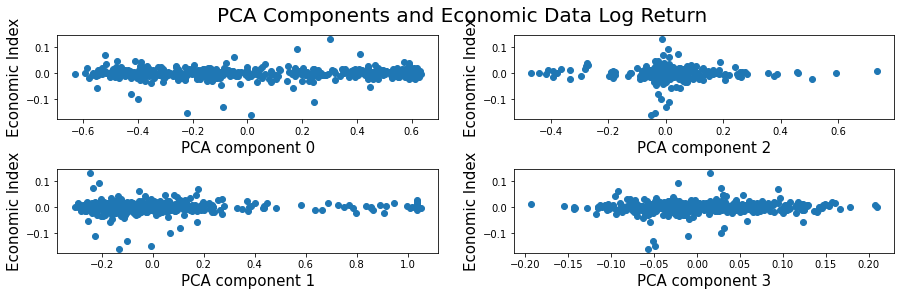

In [206]:
transformer = PCA(4).fit(DTw_train)
print("Variancia explicada: ", np.sum(transformer.explained_variance_ratio_))

DTw_train_4d = pd.DataFrame(transformer.transform(DTw_train), columns=[0,1,2,3])
DTw_test_4d = pd.DataFrame(transformer.transform(DTw_test), columns=[0,1,2,3])

fig, ax = plt.subplots(2,2,figsize=(15,4))

for i in range(2):
  for j in range(2):
    ax[i][j].scatter(DTw_train_4d[i+j*2], EILR_train)
    ax[i][j].set_xlabel("PCA component {}".format(i+j*2), fontsize=15)
    ax[i][j].set_ylabel("Economic Index", fontsize=15)

fig.suptitle("PCA Components and Economic Data Log Return", fontsize=20)
fig.subplots_adjust(hspace=0.6)
plt.show()

Apenas quatro (4) componentes principais dos dados normalizados mostraram explicar mais de 99% da variância dos preditores; no entanto, os gráficos mostram que esse fato não é suficiente: a massa principal de dados aparenta ser fracamente dependente, e se comportam sob uma reta horiontal.

## Ajuste de Modelos, Regularização e *Cross-Validation*

Com base no observado anteriormente, buscamos ajustar algumas propostas distintas:
 
  1. Ajustamos um modelo utilizando todos os preditores normalizados utilizando Lasso. Uma vez que queremos um modelo mais simple, é vantajoso favorecer a eliminação de parâmetros em excesso.
  2. Ajustamos um modelo utilizando apenas 4 componentes de PCA apresentadas anteriormente.
  3. Ajustamos um modelo considerando apenas *sentimento* e *repercussão*, com base na referencia. Aqui, damos preferencia ao modelo regularizado por Ridge, favorecendo manter coeficientes mesmo pouco expressivos.


### Regressão Utilizando Todos os Preditores (não-correlacionados)

In [207]:
# remove strongly correlated columns
corr_mat = DTw_train.corr().abs()
corr_upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
to_drop = [col for col in corr_upper.columns if any(corr_upper[col] > 0.85)]

DTw_train_decorr = DTw_train.drop(to_drop, axis = 1)
DTw_test_decorr = DTw_test.drop(to_drop, axis = 1)

# regularization hiperparameters
lambdas = np.logspace(-1,3,20)

scores = []
best_lambda = 0
best_score = -1000
for l in lambdas:
  model = LassoCV(l)
  score = cross_val_score(model, DTw_train_decorr, EILR_train).mean()
  
  scores.append(score)
  if score > best_score:
    best_score = score
    best_lambda = l
    best_model = model

best_model = Lasso(alpha=best_lambda).fit(DTw_train_decorr, EILR_train)

# scores for train and test
EILR_train_predicted = best_model.predict(DTw_train_decorr)
score_train = r2_score(EILR_train, EILR_train_predicted)

EILR_test_predicted = best_model.predict(DTw_test_decorr)
score_test = r2_score(EILR_test, EILR_test_predicted)

print("Scores \t train {}\n\t test {}".format(score_train, score_test))

Scores 	 train 0.0
	 test -0.047387140961140384


Obtivemos resultados claramente pouco expressivos.

### Regresão utilizando regressores com PCA

Utilizamos o método bastante semelhante ao anterior, mas neste ponto, interessados em usar apenas quatro preditores obtidos por PCA; estes já não-correlacionados.

In [208]:
# regularization hiperparameters
lambdas = np.logspace(-1,3,20)

scores = []
best_lambda = 0
best_score = -1000
for l in lambdas:
  model = RidgeCV(l)
  score = cross_val_score(model, DTw_train_4d, EILR_train).mean()
  
  scores.append(score)
  if score > best_score:
    best_score = score
    best_lambda = l
    best_model = model

best_model = Ridge(alpha=best_lambda).fit(DTw_train_4d, EILR_train)

# scores for train and test
EILR_train_predicted = best_model.predict(DTw_train_4d)
score_train = r2_score(EILR_train, EILR_train_predicted)

EILR_test_predicted = best_model.predict(DTw_test_4d)
score_test = r2_score(EILR_test, EILR_test_predicted)

print("Scores \t train {}\n\t test {}".format(score_train, score_test))
print("Coefficients: ", best_model.coef_)

Scores 	 train 0.006887690583881501
	 test -0.06942478384855377
Coefficients:  [ 0.0028367   0.00207191 -0.00253956  0.02154109]


### Modelo Linear Utilizando *Sentimento* e *Repercussão*

Um último modelo em que consideramos apenas parâmetros mais simples, relacionados ao sentimento (*Polaridade* e *Positividade*) e popularidade dos tweets (*Contagem de Favoritos* e *Contagem de Retweets*). Novamente, buscamos um simples modelo linear, com base na referencia. Observe que consideramos dados extremos e dados médios a cada dia. 

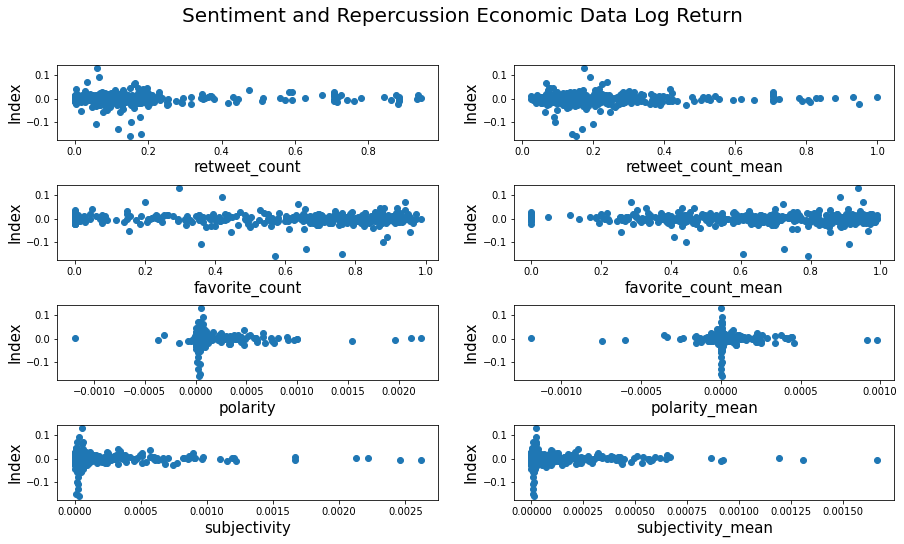

In [209]:
# predictors to be considered
sr_predictors = ["retweet_count", "favorite_count", "polarity", "subjectivity",
                 "retweet_count_mean", "favorite_count_mean",
                 "polarity_mean", "subjectivity_mean"]


fig, ax = plt.subplots(4,2, figsize = (15,8))
# extreme dayly index
for i in range(4):
  col = sr_predictors[i]
  ax[i][0].scatter(DTw_train[col], EILR_train)
  ax[i][0].set_xlabel(col, fontsize=15)
  ax[i][0].set_ylabel("Index", fontsize=15)

# mean dayly index
for i in range(4):
  col = sr_predictors[4+i]
  ax[i][1].scatter(DTw_train[col], EILR_train)
  ax[i][1].set_xlabel(col, fontsize=15)
  ax[i][1].set_ylabel("Index", fontsize=15)

fig.suptitle("Sentiment and Repercussion Economic Data Log Return", fontsize=20)
fig.subplots_adjust(hspace=0.6)
plt.show()

In [210]:
# chose Sentimental and Repercution as predictors
DTw_train_sr = DTw_train[sr_predictors]
DTw_test_sr = DTw_test[sr_predictors]

# remove strongly correlated columns
corr_mat = DTw_train_sr.corr().abs()
corr_upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
to_drop = [col for col in corr_upper.columns if any(corr_upper[col] > 0.85)]

DTw_train_decorr = DTw_train_sr.drop(to_drop, axis = 1)
DTw_test_decorr = DTw_test_sr.drop(to_drop, axis = 1)

# regularization hiperparameters
lambdas = np.logspace(-1,3,20)

scores = []
best_lambda = 0
best_score = -1000
for l in lambdas:
  model = RidgeCV(l)
  score = cross_val_score(model, DTw_train_decorr, EILR_train).mean()
  
  scores.append(score)
  if score > best_score:
    best_score = score
    best_lambda = l
    best_model = model

best_model = Ridge(alpha=best_lambda).fit(DTw_train_decorr, EILR_train)

# scores for train and test
EILR_train_predicted = best_model.predict(DTw_train_decorr)
score_train = r2_score(EILR_train, EILR_train_predicted)

EILR_test_predicted = best_model.predict(DTw_test_decorr)
score_test = r2_score(EILR_test, EILR_test_predicted)

print("Scores \t train {}\n\t test {}".format(score_train, score_test))
print("Coefficients: ", best_model.coef_)

Scores 	 train 0.007526801842901887
	 test -0.06554601279106698
Coefficients:  [-0.00682872 -0.01233088 -2.9561449   4.17468472 -0.01272372 -0.01151623
  1.52662571 -3.94917282]


Surpreendentemente, obtivemos coeficientes significativos em primeira análise, em comparação com o obtido em PCA, especialmente para os dados relacionaods ao sentimento nas postagens, em que obtivemos coeficientes verdadeiramente expressivos, o que sequer era esperado; no entanto, o modelo ainda apresenta um ajuste ruim aos dados de treino. Esse fato deverá ser discutido logo mais.  

## Significância dos Coeficientes

Revisitamos o último modelo, em que obtivemos os coeficientes mais expressivos: gostaríamos de discutir se esses coeficientes são verdadeiramente (estatisticamente) significanes, ou apenas resultado de efeitos randômicos.

In [212]:
# Discuss a test at a 95% significance

## Discussão dos Coeficientes e Modelo

Com base nos resultados anteriores, embora tenhamos obtido resultados estatísticamente relevantes, questionamos o modelo: não é de se esperar influencia demasiadamente forte entre a rede social da família do presidente, e o mercado, embora este seja volátil, e sensível a perturbações.


##########################################################

Ainda não fiz o teste de significancia, mas estou estranhando o resultado. Mesmo obtendo significancia estatística considerável, devemos questionar o quanto disso é correlação. Não ajustei um modelo com retardo. Talvez seja interessante de se fazer isso mesmo... E discutir se os coeficientes fazem sentido, etc...

##########################################################

## Resultados

###############################################################

Concluímos discutindo aspectos gerais...

###############################################################